In [3]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import cv2 as cv

from tensorflow.keras.applications.resnet50 import ResNet50 as Model, preprocess_input, decode_predictions
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array

from tf_keras_vis.utils import num_of_gpus


In [2]:
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [71]:
if os.path.isfile('imagenet_class_index.json') == False:
    !wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

import json

CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
    
print("N of class={}".format(len(classlabel)))

N of class=1000


In [ ]:
# os.chdir("Imagenet-Patch physical applications\images_with_patches")

In [ ]:
# x = []

# # Load images and Convert them to a Numpy array
# for file in os.listdir():

#     img = load_img(file, target_size=(224, 224))
#     img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)

#     # Preparing input data for VGG16
#     x.append(img.copy())
    
#     tmp_img = preprocess_input(img.copy())
#     img_pred = model.predict(tmp_img)
#     prediction = decode_predictions(img_pred, top=1)
#     prediction

# #     class_lbl = classlabel.index(prediction[0][0][1])
# #     print(prediction, class_lbl)
    
#     # Rendering
#     plt.figure(figsize=(3, 4))
#     plt.title(file + '\n' + str(prediction[0][0][1]) + str(prediction[0][0][2]), fontsize=16)
#     plt.imshow(np.uint8(img[0]))
#     plt.axis('off')
#     plt.tight_layout()
    


## VERY LESS Attack accuracy of the dataset, need to change the dataset and test on APRICOT dataset

1/1 [==============================] - 0s 128ms/step


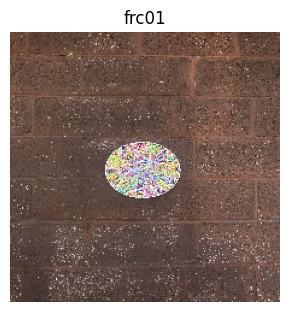

In [109]:
x = []
img = load_img('frc4_0.jpg', target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

# Preparing input data for VGG16
x.append(img.copy())

tmp_img = preprocess_input(img.copy())
img_pred = model.predict(tmp_img)
prediction = decode_predictions(img_pred, top=1)
prediction

#     class_lbl = classlabel.index(prediction[0][0][1])
#     print(prediction, class_lbl)

# Rendering
plt.figure(figsize=(3, 4))
plt.title('frc01')
plt.imshow(np.uint8(img[0]))
plt.axis('off')
plt.tight_layout()

1/1 [==============================] - 0s 129ms/step


([[('n04548362', 'wallet', 0.22680093)]], 893)

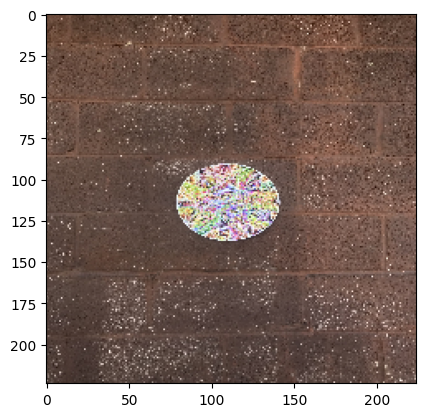

In [112]:
selected_img = x[0]
plt.imshow(np.uint8(selected_img[0]))

tmp_img = selected_img.copy()
tmp_img = preprocess_input(tmp_img)

img_pred = model.predict(tmp_img)
prediction = decode_predictions(img_pred, top=1)
class_lbl = classlabel.index(prediction[0][0][1])
prediction, class_lbl

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function.

In [111]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

And then, you MUST create Score instance or define score function that returns target scores. Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.

In [113]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore(class_lbl)

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

# GradCAM

Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

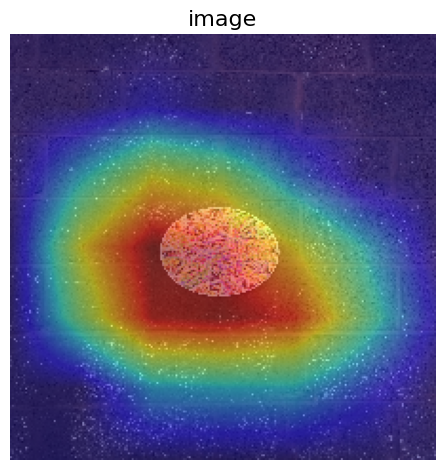

In [114]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

image_titles = ['image']
# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              x[0].copy(),
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.title(title, fontsize=16)
    plt.imshow(np.uint8(x[0][0]))
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    plt.axis('off')
    plt.tight_layout()

In [115]:
tmp_heatmap = heatmap.copy()

In [116]:
img_tmp = x[0] / 255.

(-0.5, 223.5, 223.5, -0.5)

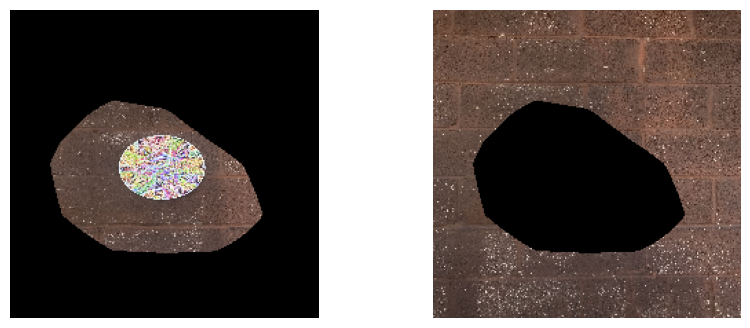

In [117]:
patch_mask = cam[i].copy()
# plt.imshow(img_tmp[0])
# plt.imshow(xx, cmap='gray')

patch_mask[np.where(patch_mask > 0.5)] = 1.
patch_mask[np.where(patch_mask <= 0.5)] = 0.

image_mask = np.where(patch_mask==1., 0., 1.)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

r = np.multiply(patch_mask, img_tmp[0, :, :, 0])
g = np.multiply(patch_mask, img_tmp[0, :, :, 1])
b = np.multiply(patch_mask, img_tmp[0, :, :, 2])
rgb_patch = np.dstack((r,g,b))

axes[0].imshow(rgb_patch)
axes[0].axis('off')

r = np.multiply(image_mask, img_tmp[0, :, :, 0])
g = np.multiply(image_mask, img_tmp[0, :, :, 1])
b = np.multiply(image_mask, img_tmp[0, :, :, 2])
rgb_image = np.dstack((r,g,b))

axes[1].imshow(rgb_image)
axes[1].axis('off')

In [118]:
# # Filter 1
# kernel = np.ones((5,5),np.float32)/25

# blr1 = cv.filter2D(rgb_patch,-1,kernel)

# plt.imshow(blr1)

In [119]:
# # Filter 2
# blr2 = cv.blur(rgb_patch,(5,5))

# plt.imshow(blr2)

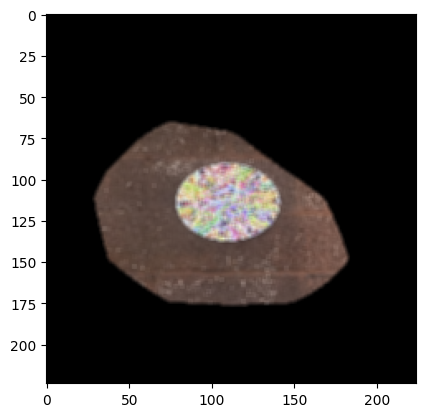

In [120]:
# Gaussian Blur
blur = cv.GaussianBlur(rgb_patch.copy(), (3,3), 10)

# # Median Blue
# blur = cv.medianBlur(rgb_patch.copy(),5)


plt.imshow(blur)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

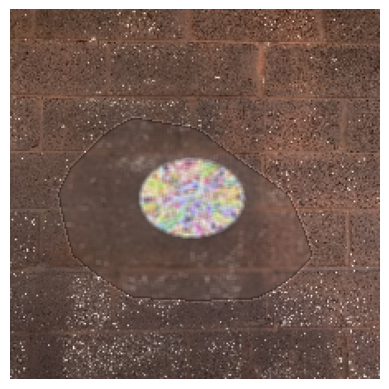

In [121]:
blur_img = blur.copy() + rgb_image.copy()
plt.imshow(blur_img)
plt.axis('off')

In [122]:
new_x = np.expand_dims(blur_img.copy(), axis=0)

# Preparing input data for VGG16
inp_x = preprocess_input(new_x.copy())

blur_img_pred = model.predict(inp_x.copy())
blur_pred = decode_predictions(blur_img_pred, top=1)
blur_pred

blur_class_lbl = classlabel.index(blur_pred[0][0][1])
blur_pred, blur_class_lbl

1/1 [==============================] - 0s 172ms/step


([[('n06359193', 'web_site', 0.07027619)]], 916)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


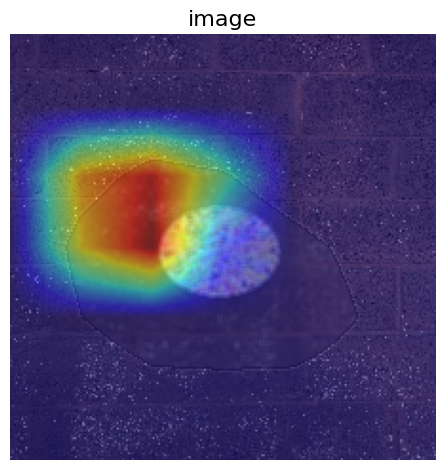

In [123]:
# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              inp_x.copy(),
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.title(title, fontsize=16)
    plt.imshow(new_x[0])
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    plt.axis('off')
    plt.tight_layout()

In [ ]:
# manjunah sir
# # take the values in the salience region and fill in the patch region with it

# # color characterstics- usually done by pdf, cdf

# # adversarial training for training

# shruti maam

# guided gradcam
# filters - gaussian, etc